# 00 - Getting Started with `evosax` - The Ask-Eval-Tell API
### [Last Update: March 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/00_getting_started.ipynb)

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q git+https://github.com/RobertTLange/evosax.git@main
!pip install -q gymnax

## Evolution Strategy Instantiation

In [1]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES
from evosax.problems import BBOBFitness

# Instantiate the evolution strategy instance
strategy = CMA_ES(num_dims=2, popsize=10)

# Get default hyperparameters (e.g. lrate, etc.)
es_params = strategy.default_params
es_params = es_params.replace(init_min= -3, init_max=3)

# Initialize the strategy
rng = jax.random.PRNGKey(0)
state = strategy.initialize(rng, es_params)

# Have a look at the hyperparameters (change if desired)
es_params

EvoParams(mu_eff=DeviceArray(3.1672993, dtype=float32), c_1=DeviceArray(0.14227484, dtype=float32), c_mu=DeviceArray(0.1547454, dtype=float32), c_sigma=DeviceArray(0.50822735, dtype=float32), d_sigma=DeviceArray(1.5082273, dtype=float32), c_c=DeviceArray(0.60908335, dtype=float32), chi_n=DeviceArray(1.2542727, dtype=float32, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-3, init_max=3, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

## Classic Evolution Strategy Benchmarks

In [2]:
# Instantiate helper class for classic evolution strategies benchmarks
evaluator = BBOBFitness("RosenbrockOriginal", num_dims=2)

Given our initialized strategy we are now ready to `ask` for a set of candidate parameters. Afterwards, we evaluate these on the 2D Rosenbrock problem and `tell` them to our strategy. The strategy will update its `state` and we can iterate.

In [3]:
# Ask for a set of candidate solutions to evaluate
x, state = strategy.ask(rng, state, es_params)
# Evaluate the population members
fitness = evaluator.rollout(rng, x)
# Update the evolution strategy
state = strategy.tell(x, fitness, state, es_params)
state

EvoState(p_sigma=DeviceArray([1.4210665 , 0.17011967], dtype=float32), p_c=DeviceArray([1.5021834, 0.1798304], dtype=float32), C=DeviceArray([[1.6521862, 0.2126719],
             [0.2126719, 0.6064514]], dtype=float32), D=None, B=None, mean=DeviceArray([-0.7851852,  1.9345263], dtype=float32), sigma=DeviceArray(1.0486844, dtype=float32), weights=DeviceArray([ 0.45627266,  0.27075312,  0.16223112,  0.08523354,
              0.02550957, -0.09313666, -0.25813875, -0.4010702 ,
             -0.5271447 , -0.639922  ], dtype=float32), weights_truncated=DeviceArray([0.45627266, 0.27075312, 0.16223112, 0.08523354, 0.02550957,
             0.        , 0.        , 0.        , 0.        , 0.        ],            dtype=float32), best_member=DeviceArray([0.7087054, 2.3278952], dtype=float32), best_fitness=DeviceArray(17.166704, dtype=float32), gen_counter=DeviceArray(1, dtype=int32, weak_type=True))

## Running the ES Loop with Logging

In [4]:
from evosax.utils import ESLog
# Jittable logging helper
num_gens = 50
es_logging = ESLog(num_dims=2, num_generations=num_gens, top_k=3, maximize=False)
log = es_logging.initialize()

(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'2D Rosenbrock CMA-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

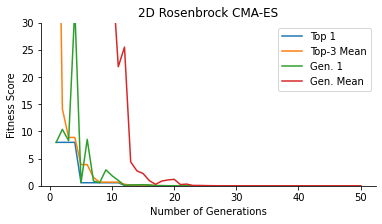

In [5]:
state = strategy.initialize(rng, es_params)
for i in range(num_gens):
    rng, rng_ask = jax.random.split(rng)
    # Ask for a set candidates
    x, state = strategy.ask(rng_ask, state, es_params)
    # Evaluate the candidates
    fitness = evaluator.rollout(rng, x)
    # Update the strategy based on fitness
    state = strategy.tell(x, fitness, state, es_params)
    # Update the log with results
    log = es_logging.update(log, x, fitness)
    
es_logging.plot(log, "2D Rosenbrock CMA-ES", ylims=(0, 30))

## Simultaneous PyTree Evaluation with `evosax`'s `ParameterReshaper`

`evosax` supports the automatic reshaping of proposed flat vectors into Pytrees for smooth neural network fitness evaluations. The transformation is again JAX-composable (`jit`, `vmap`, etc.). Below you find an example for a flax-based multi-layer perceptron:

In [6]:
from flax import linen as nn


class MLP(nn.Module):
    """Simple ReLU MLP."""

    num_hidden_units: int
    num_hidden_layers: int
    num_output_units: int

    @nn.compact
    def __call__(self, x, rng):
        for l in range(self.num_hidden_layers):
            x = nn.Dense(features=self.num_hidden_units)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_output_units)(x)
        return jax.random.categorical(rng, x)
    

# Instantiate the model callables and get a placeholder pytree
network = MLP(64, 2, 2)
policy_params = network.init(rng, jnp.zeros(4,), rng)

In [7]:
from evosax.utils import ParameterReshaper

# Instantiate the reshape helper & get total number of parameters to reshape
param_reshaper = ParameterReshaper(policy_params)
param_reshaper.total_params

ParameterReshaper: 4610 parameters detected for optimization.


4610

Now let's instantiate another evolution strategy (`DE` - Differential Evolution) and generate a set of generation members: 

In [8]:
from evosax import DE
strategy = DE(popsize=100, num_dims=param_reshaper.total_params)
state = strategy.initialize(rng, strategy.default_params)
x, state = strategy.ask(rng, state, strategy.default_params)
x.shape

(100, 4610)

As we can see this is simply an array with (#population members, #parameters) shape. In order to reshape this array into stacked pytrees, we can simply pass it to the reshaper:

In [9]:
net_params = param_reshaper.reshape(x)
net_params.keys(), net_params['params']['Dense_0']['kernel'].shape

(frozen_dict_keys(['params']), (100, 4, 64))

## Fitness Shaping with `evosax`'s `FitnessShaper`

By default `evosax` will minimize the objective. If you want to instead maximize it (as you commonly do with RL returns) or want to apply any other common ES fitness shaping, you can use the `FitnessShaper`:

In [10]:
from evosax import FitnessShaper
fit_shaper = FitnessShaper(centered_rank=True, w_decay=0.01, maximize=True)

x = jnp.array([[1.0], [2.0], [3.0]])
fit = jnp.array([0.0, 1.0, 2.0])
fit_shaper.apply(x, fit)

DeviceArray([ 0.49, -0.04, -0.59], dtype=float32)

## ARS on CartPole Task

`evosax` also comes with a simple fitness evaluation helper for all [`gymnax`](https://github.com/RobertTLange/gymnax) environments (e.g. CartPole, MinAtar, etc.). We will vectorize the rollouts of the different population members:

In [11]:
from evosax.problems import GymnaxFitness

evaluator = GymnaxFitness("CartPole-v1", num_env_steps=200, num_rollouts=16)
evaluator.set_apply_fn(network.apply)

In [12]:
from evosax import ARS

strategy = ARS(popsize=100,
               num_dims=param_reshaper.total_params,
               elite_ratio=0.1, opt_name="sgd")

es_params = strategy.default_params
es_params = es_params.replace(opt_params=es_params.opt_params.replace(momentum=0.0))
es_params

EvoParams(opt_params=OptParams(lrate_init=0.05, lrate_decay=1.0, lrate_limit=0.001, momentum=0.0, beta_1=None, beta_2=None, beta_3=None, eps=None, max_speed=None), sigma_init=0.03, sigma_decay=1.0, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


Generation:  0 Performance:  22.875
Generation:  5 Performance:  26.25
Generation:  10 Performance:  27.8125
Generation:  15 Performance:  31.3125
Generation:  20 Performance:  53.0
Generation:  25 Performance:  99.0625
Generation:  30 Performance:  115.8125
Generation:  35 Performance:  130.125
Generation:  40 Performance:  192.9375
Generation:  45 Performance:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole Augmented Random Search'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

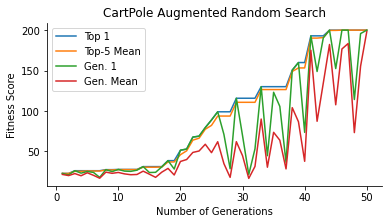

In [13]:
num_generations = 50
num_rollouts = 20
print_every_k_gens = 5

rng = jax.random.PRNGKey(0)
es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()
fit_shaper = FitnessShaper(maximize=True)

state = strategy.initialize(rng, es_params)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Performance: ", -state.best_fitness)
    #break
        
es_logging.plot(log, "CartPole Augmented Random Search")

# More Minimalism (no `es_params`, `fit_shaper` or `param_reshaper`)

We also provide utilities that abstract away all the details if you are only interested in a default implementation or want to avoid 10 additional lines of boilerplate code :)

This means that you can directly provide the placeholder parameters and fitness shaping arguments at the time of strategy instantiation. Furthermore, if you don't explicitly provide `es_params` at the time of `initialize`, `ask`, `tell` the strategy will use a set of default parameters:

In [14]:
strategy = ARS(popsize=100,
               pholder_params=policy_params,
               elite_ratio=0.1,
               opt_name="sgd",
               maximize=True)

ParameterReshaper: 4610 parameters detected for optimization.


Generation:  0 Performance:  22.875
Generation:  5 Performance:  26.25
Generation:  10 Performance:  27.8125
Generation:  15 Performance:  31.3125
Generation:  20 Performance:  53.0
Generation:  25 Performance:  99.0625
Generation:  30 Performance:  115.8125
Generation:  35 Performance:  130.125
Generation:  40 Performance:  192.9375
Generation:  45 Performance:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole Augmented Random Search'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

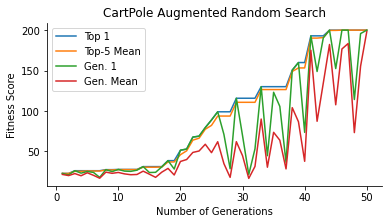

In [15]:
num_generations = 50
num_rollouts = 20
print_every_k_gens = 5

rng = jax.random.PRNGKey(0)
es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)

# No es_params!
state = strategy.initialize(rng)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state)
    fitness = evaluator.rollout(rng_eval, x).mean(axis=1)
    state = strategy.tell(x, fitness, state)
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Performance: ", state.best_fitness)
    #break
        
es_logging.plot(log, "CartPole Augmented Random Search")